## Importing Libraries and Setting Up

In [37]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Input, Dense, Embedding, LSTM, Dropout, Reshape, Concatenate, add, Flatten
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import pickle

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

## Data Loading and Preprocessing

In [38]:
image_path = '/Users/swathibaskaran/Desktop/ICG/flickr8k/Images'
file_path = '/Users/swathibaskaran/Desktop/ICG/flickr8k/captions.txt'

# Reading the file
data = pd.read_csv(file_path)

# Displaying the first few rows
data.head()


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [39]:
# Function to read and preprocess images
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0
    return img

# Function to display images with captions
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(15):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image = readImage(f"/Users/swathibaskaran/Desktop/ICG/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

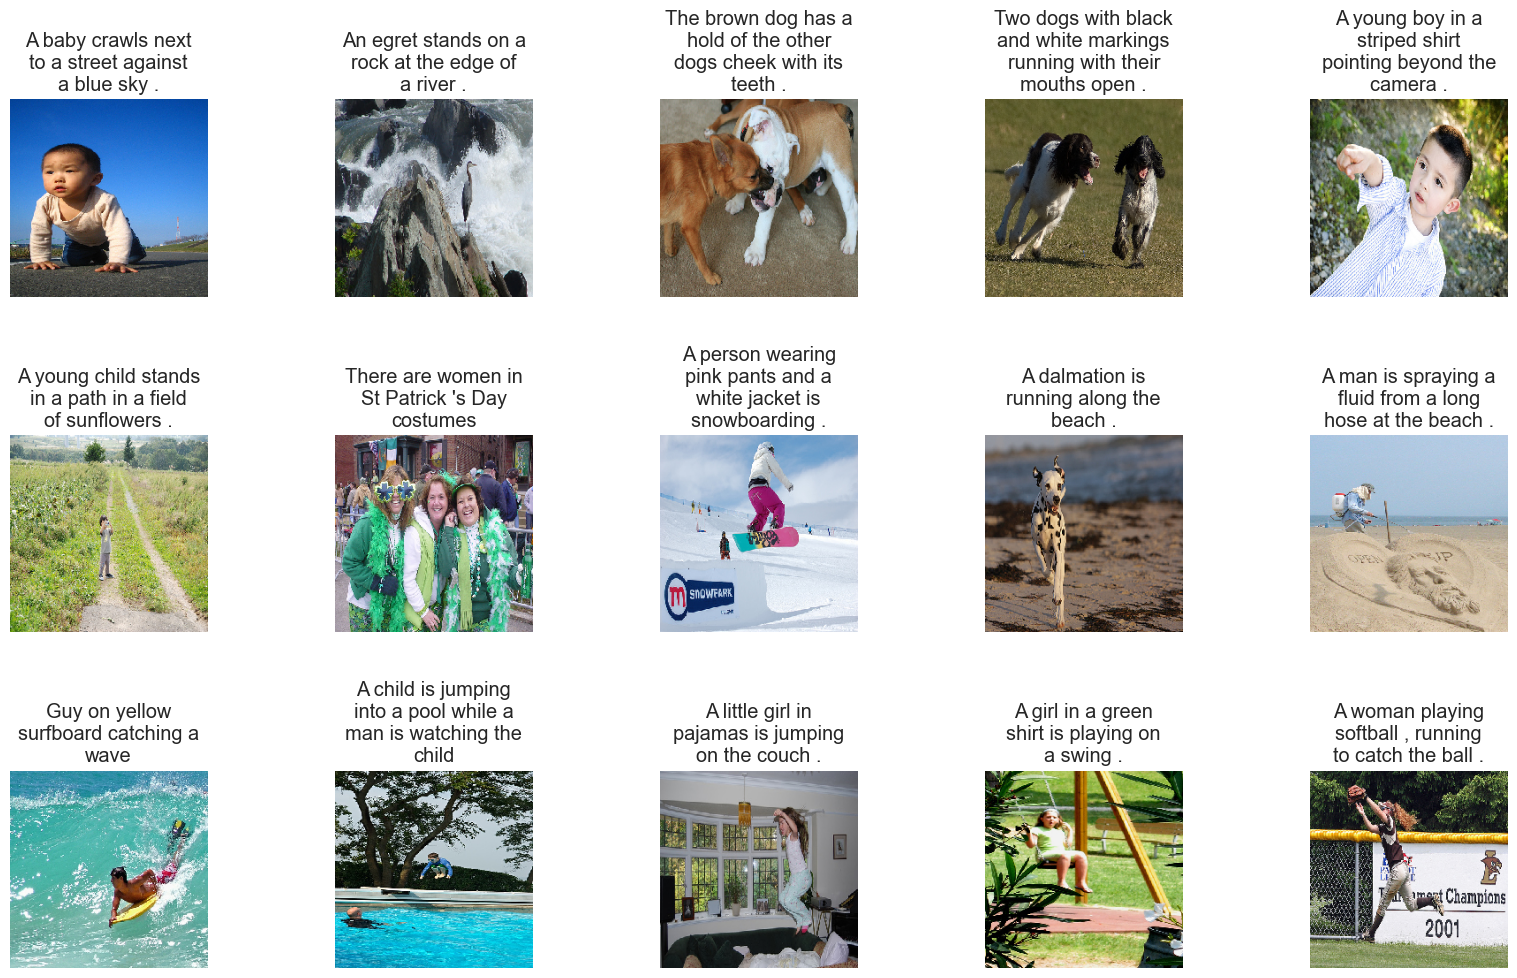

In [40]:
display_images(data.sample(15))

## Text Processing

In [41]:
# Function to preprocess text data
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]", ""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+", " "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    data['caption'] = "startseq " + data['caption'] + " endseq"
    return data

# Preprocess captions
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## Tokenization and Splitting Data

In [42]:
# Tokenize captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

# Split data into training and validation sets
images = data['image'].unique().tolist()
nimages = len(images)
split_index = round(0.85 * nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

## Feature Extracting using Pretrained Model - DenseNet201

In [43]:
# Load pretrained DenseNet201 model for feature extraction
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

# Extract features from images
img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature


100%|██████████| 8091/8091 [10:30<00:00, 12.84it/s]


## Custom Data Generator

In [44]:
# Custom data generator class
class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, vocab_size, max_length, features, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self, batch):
        X1, X2, y = list(), list(), list()
        images = batch[self.X_col].tolist()
        for image in images:
            feature = self.features[image][0]
            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        return X1, X2, y

## Implement Attention Mechanism

In [45]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

plt.rcParams['font.size'] = 12
sns.set_style("dark")

nltk.download('punkt')

# Define Attention and TileLayer if not already defined
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return output

class TileLayer(Layer):
    def __init__(self, max_length, **kwargs):
        super(TileLayer, self).__init__(**kwargs)
        self.max_length = max_length

    def call(self, inputs):
        return tf.tile(inputs, [1, self.max_length, 1])

    def get_config(self):
        config = super(TileLayer, self).get_config()
        config.update({"max_length": self.max_length})
        return config




[nltk_data] Downloading package punkt to
[nltk_data]     /Users/swathibaskaran/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Building Model with LSTM

In [47]:
# Function to build the model if not already defined
def build_model(vocab_size, max_length):
    input1 = Input(shape=(1920,))
    input2 = Input(shape=(max_length,))

    img_features = Dense(256, activation='relu')(input1)
    img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)
    img_features_tiled = TileLayer(max_length)(img_features_reshaped)

    sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
    merged = Concatenate()([img_features_tiled, sentence_features])

    attention = Attention()(merged)
    sentence_features = LSTM(256, return_sequences=False)(attention)
    sentence_features = Dense(256, activation='relu')(sentence_features)

    img_features_flat = Flatten()(img_features_tiled)
    img_features_dense = Dense(256, activation='relu')(img_features_flat)

    combined_features = add([sentence_features, img_features_dense])
    x = Dense(128, activation='relu')(combined_features)
    x = Dropout(0.5)(x)
    output = Dense(vocab_size, activation='softmax')(x)

    caption_model = Model(inputs=[input1, input2], outputs=output)
    caption_model.compile(loss='categorical_crossentropy', optimizer='adam')
    return caption_model

# Build the model
caption_model = build_model(vocab_size, max_length)


In [48]:
!pip3 install pydot

  Obtaining dependency information for pydot from https://files.pythonhosted.org/packages/9a/fd/df3932340498a8f38c6107c95b0eb1d9ac406c5ea1307c8f43408977378e/pydot-3.0.1-py3-none-any.whl.metadata


In [50]:
plot_model(caption_model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [51]:
caption_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 256)       │    491,776 │ input_layer_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_10          │ (None, 1, 256)    │          0 │ dense_23[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_23      │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tile_layer_5        │ (None, 34, 256)   │          0 │ reshape_10[0][0]  │
│ (TileLayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 34, 256)   │  2,172,160 │ input_layer_23[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 34, 512)   │          0 │ tile_layer_5[0][… │
│ (Concatenate)       │                   │            │ embedding_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_8         │ (None, 34, 512)   │    262,656 │ concatenate_9[0]… │
│ (Attention)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 256)       │    787,456 │ attention_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 8704)      │          0 │ tile_layer_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 256)       │     65,792 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 256)       │  2,228,480 │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 256)       │          0 │ dense_24[0][0],   │
│                     │                   │            │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 128)       │     32,896 │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 8485)      │  1,094,565 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,135,781 (27.22 MB)

 Trainable params: 7,135,781 (27.22 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [52]:
# Training code remains the same
train_generator = CustomDataGenerator(df=train, X_col='image', y_col='caption', batch_size=64, directory=image_path,
                                      tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

validation_generator = CustomDataGenerator(df=test, X_col='image', y_col='caption', batch_size=64, directory=image_path,
                                           tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)


In [53]:
history = caption_model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping, learning_rate_reduction])


Epoch 1/40
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 5.8389
Epoch 1: val_loss improved from inf to 4.41519, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 1094s 2s/step - loss: 5.8378 - val_loss: 4.4152 - learning_rate: 0.0010
Epoch 2/40
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - loss: 4.4029
Epoch 2: val_loss improved from 4.41519 to 4.05996, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 219s 407ms/step - loss: 4.4027 - val_loss: 4.0600 - learning_rate: 0.0010
Epoch 3/40
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - loss: 4.0640
Epoch 3: val_loss improved from 4.05996 to 3.89516, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 218s 405ms/step - loss: 4.0639 - val_loss: 3.8952 - learning_rate: 0.0010
Epoch 4/40
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - loss: 3.8788
Epoch 4: val_loss improved from 3.89516 to 3.82625, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 218s 406ms/step - loss: 3.8787 - val_loss: 3.8263 - learning_rate: 0.0010
E

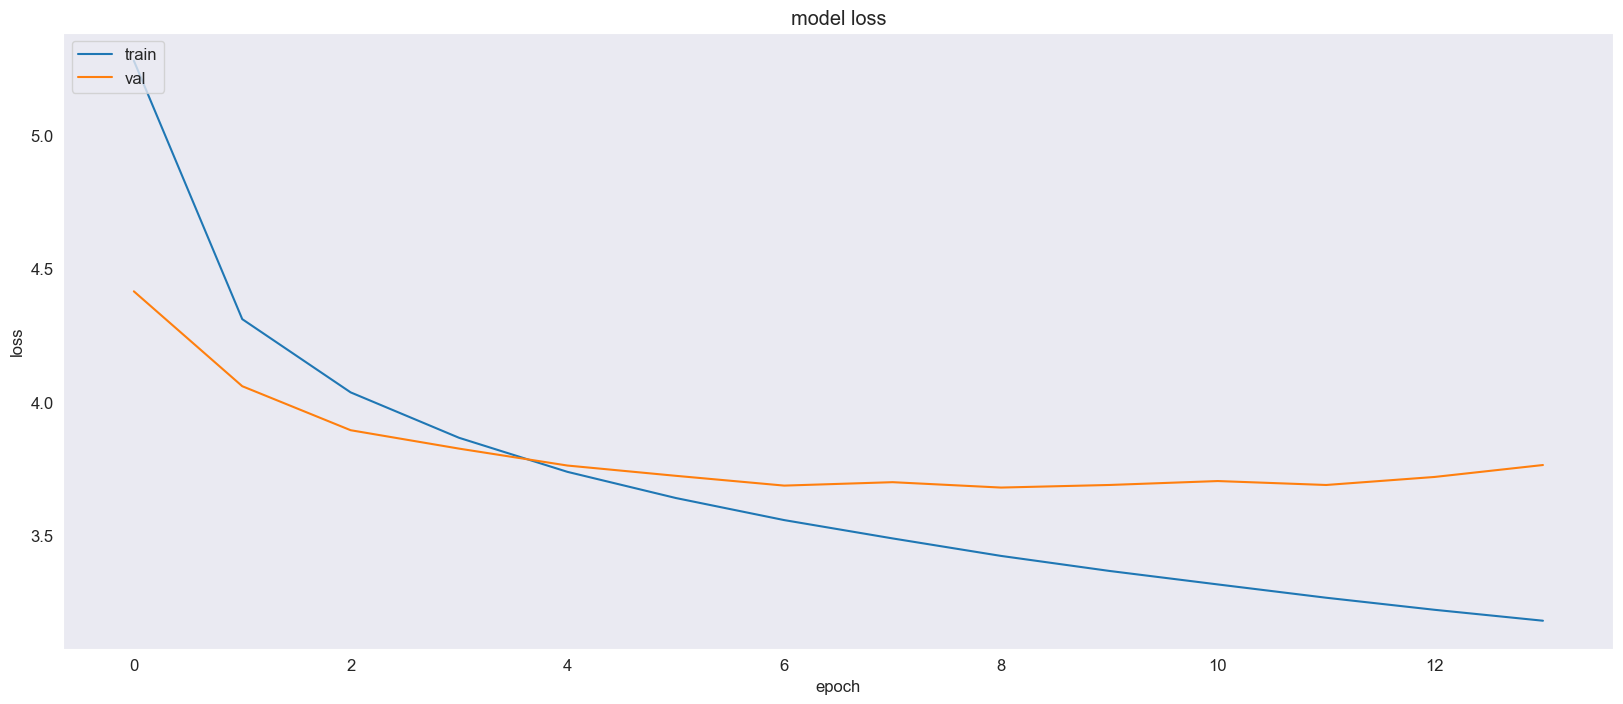

In [54]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Save pickle files

In [55]:
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the features
with open('features.pkl', 'wb') as handle:
    pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Load the model and Tokenizer

In [57]:
from tensorflow.keras.models import load_model
# Load the tokenizer and model
tokenizer_path = 'tokenizer.pkl'
model_path = 'model.keras'
features_path = 'features.pkl'

# Load the tokenizer
with open(tokenizer_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load the trained model with custom layers
caption_model = load_model(model_path, custom_objects={'Attention': Attention, 'TileLayer': TileLayer})

# Load features
with open(features_path, 'rb') as handle:
    features = pickle.load(handle)

# Set the maximum length of the caption
max_length = 34  # Adjust this if necessary


## Caption Prediction 

In [59]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length, features):
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        y_pred = model.predict([feature, sequence], verbose=0)
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text += " " + word

        if word == 'endseq':
            break

    return in_text.replace('startseq', '').replace('endseq', '').strip()


## Generate Captions and Calculate BLEU Score

In [60]:
# Assuming 'test' is your DataFrame with the test set
generated_captions = []
reference_captions = []

for idx, row in test.iterrows():
    image = row['image']
    reference_caption = row['caption']
    generated_caption = predict_caption(caption_model, image, tokenizer, max_length, features)
    
    generated_captions.append(generated_caption.split())
    reference_captions.append([reference_caption.split()])


In [61]:
smoothing_function = SmoothingFunction().method4
bleu_scores = [sentence_bleu(ref, gen, smoothing_function=smoothing_function) for ref, gen in zip(reference_captions, generated_captions)]

# Average BLEU score
average_bleu = np.mean(bleu_scores)
print(f'Average BLEU Score: {average_bleu:.4f}')


Average BLEU Score: 0.0331


## Evaluating BLEU score for Test images

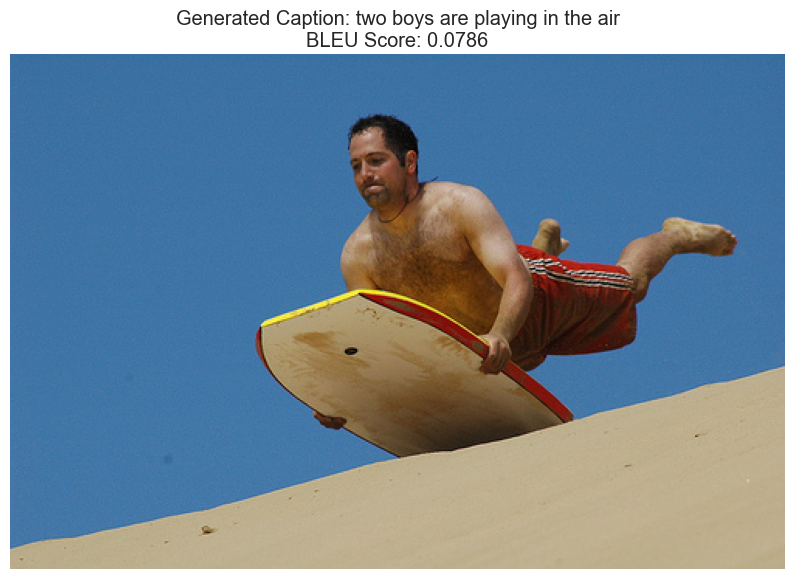

Generated Caption: two boys are playing in the air
BLEU Score: 0.0786


In [64]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Function to read a single image
def read_image_for_prediction(path, img_size=224):
    img = load_img(path, target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Function to extract features for a single image using the DenseNet201 model
def extract_features_for_image(img_path, fe_model):
    img = read_image_for_prediction(img_path)
    feature = fe_model.predict(img, verbose=0)
    return feature

# Function to predict caption for a single image
def predict_caption_for_image(model, image_feature, tokenizer, max_length):
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        y_pred = model.predict([image_feature, sequence], verbose=0)
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text += " " + word

        if word == 'endseq':
            break

    return in_text.replace('startseq', '').replace('endseq', '').strip()

# Function to evaluate the caption using BLEU score
def evaluate_caption(reference_captions, generated_caption):
    references = [ref.split() for ref in reference_captions]
    generated = generated_caption.split()
    smoothing_function = SmoothingFunction().method4
    bleu_score = sentence_bleu(references, generated, smoothing_function=smoothing_function)
    return bleu_score

# Function to display the image, generated caption, and BLEU score
def display_image_with_caption(image_path, generated_caption, bleu_score):
    plt.figure(figsize=(10, 10))
    img = load_img(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Generated Caption: {generated_caption}\nBLEU Score: {bleu_score:.4f}')
    plt.show()

# Example usage
image_id = '96420612_feb18fc6c6'  # Replace with your image ID
image_path = f'/Users/swathibaskaran/Desktop/ICG/flickr8k/Images/{image_id}.jpg'  # Replace with the path to your images

# Load the feature extraction model (DenseNet201)
fe_model = DenseNet201(weights='imagenet', include_top=False, pooling='avg')

# Extract features for the image
image_feature = extract_features_for_image(image_path, fe_model)

# Predict caption for the image
generated_caption = predict_caption_for_image(caption_model, image_feature, tokenizer, max_length)

# Get the reference captions for the image
reference_captions = data[data['image'] == f'{image_id}.jpg']['caption'].tolist()

# Evaluate the generated caption using BLEU score
bleu_score = evaluate_caption(reference_captions, generated_caption)

# Display the image, generated caption, and BLEU score
display_image_with_caption(image_path, generated_caption, bleu_score)



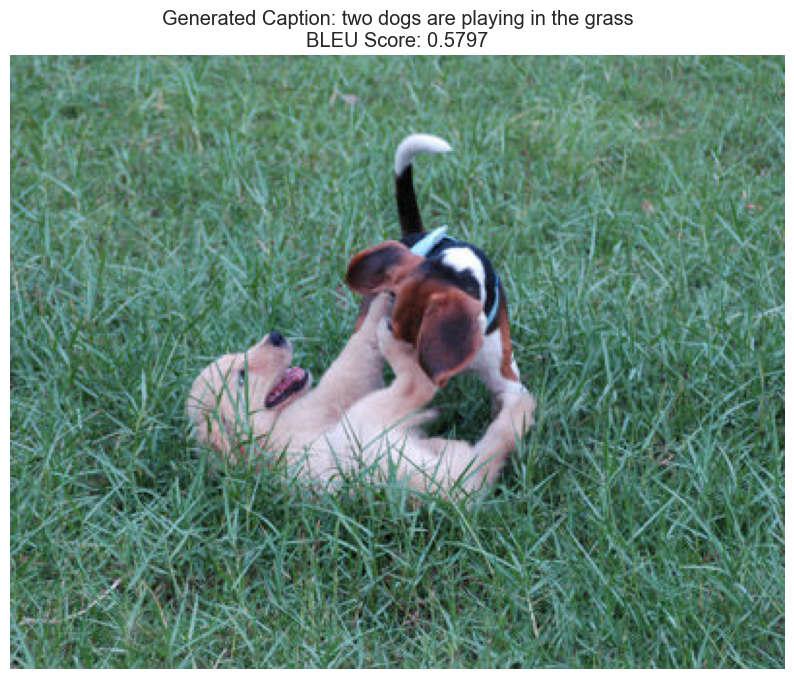

In [68]:
# Example usage
image_id = '23445819_3a458716c1'  # Replace with your image ID
image_path = f'/Users/swathibaskaran/Desktop/ICG/flickr8k/Images/{image_id}.jpg'  # Replace with the path to your images

# Load the feature extraction model (DenseNet201)
fe_model = DenseNet201(weights='imagenet', include_top=False, pooling='avg')

# Extract features for the image
image_feature = extract_features_for_image(image_path, fe_model)

# Predict caption for the image
generated_caption = predict_caption_for_image(caption_model, image_feature, tokenizer, max_length)

# Get the reference captions for the image
reference_captions = data[data['image'] == f'{image_id}.jpg']['caption'].tolist()

# Evaluate the generated caption using BLEU score
bleu_score = evaluate_caption(reference_captions, generated_caption)

# Display the image, generated caption, and BLEU score
display_image_with_caption(image_path, generated_caption, bleu_score)